<a href="https://colab.research.google.com/github/XiangxiangXu/comm_symb/blob/main/Milcom_SymbolDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for [Multiuser Detection With Neural Feature Learning](https://ieeexplore.ieee.org/document/10773687)

- add batchnorm
- use softplus
- sufficient stat. & fourier features
- gpu support on training, inference with large input
- random $\|h_1\|, \|h_2\|$, Rayleigh or uniform over complex circles
- fix $P_1$ = $P_2$


### Settings

In [1]:
import os
import torch
import numpy as np
import random
def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# seed = 0
# setup_seed(seed) # randomness control

In [2]:
####################
# Imports and CUDA #
####################

import numpy as np
from scipy.stats import multivariate_normal
import csv
import random
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim, hstack

from matplotlib import pyplot as plt
import matplotlib.colors as colors

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))

else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [3]:
CONSTELLATION = {
    "BPSK": [[1, 0], [-1, 0]],
    "16QAM": [
        [-3 / 4, -3 / 4],
        [-1 / 4, -3 / 4],
        [-3 / 4, -1 / 4],
        [-1 / 4, -1 / 4],
        [3 / 4, -3 / 4],
        [1 / 4, -3 / 4],
        [3 / 4, -1 / 4],
        [1 / 4, -1 / 4],
        [-3 / 4, 3 / 4],
        [-1 / 4, 3 / 4],
        [-3 / 4, 1 / 4],
        [-1 / 4, 1 / 4],
        [3 / 4, 3 / 4],
        [1 / 4, 3 / 4],
        [3 / 4, 1 / 4],
        [1 / 4, 1 / 4],
    ],
}

cnt_symbols = len(CONSTELLATION["BPSK"]) * len(CONSTELLATION["16QAM"])
total_symbols = len(CONSTELLATION["BPSK"]) + len(CONSTELLATION["16QAM"])

In [4]:
#####################
# Channel constants #
#####################

P1 = 1 # power for user 1 (energy per symbol)
P2 = 1 # power for user 2
N_0 = 1/2 # noise power

# SNR = 10 * np.log10(P1 * |h1|^2 / N_0)
# SINR = 10 * np.log10(P1 * |h1|^2 / (P2 * |h2|^2 + N_0))
#print(f"SNR: {round(10 * np.log10(SNR), 2)} db")
#print(f"SINR: {round(10 * np.log10(SINR), 2)} db")

# set user i: BPSK, user ii: 16QAM
# ratios to set P1 and P2 to be desired

r1 = np.sqrt(P1)       # P1 = r1 ** 2, as user 1 is BPSK
r2 = np.sqrt(P2 * 8/5) # P2 = (r2 ** 2) * 5/8, for 16QAM

user_i_constellation = [[r1 * coord for coord in el] for el in CONSTELLATION['BPSK']]
user_ii_constellation = [[r2 * coord for coord in el] for el in CONSTELLATION['16QAM']]

user_i_tensor = [torch.tensor(x, dtype=torch.float) for x in user_i_constellation]
user_ii_tensor = [torch.tensor(x, dtype=torch.float) for x in user_ii_constellation]

user_i_np = [np.array([x]).T for x in user_i_constellation]
user_ii_np = [np.array([x]).T for x in user_ii_constellation]

Sanity check: average powers

In [5]:
print('P1', np.mean([s.norm() ** 2 for s in user_i_tensor]))
print('P2', np.mean([s.norm() ** 2 for s in user_ii_tensor]))

P1 1.0
P2 1.0


In [6]:
def complex_multiply(h, x):
    """
    takes in tensors h and x,
    each row assumed to be a complex number
    return complex multiplication hx
    """
    return torch.hstack([
        h[:,:1] * x[:,:1] - h[:,1:] * x[:,1:],
        h[:,:1] * x[:,1:] + h[:,1:] * x[:,:1]]
    )

In [7]:
# generate dataset for given h_list
def gen_dataset_h_list(h, N_0 = 1):
    N = h.shape[0]
    h1 = h[:,:2]
    h2 = h[:,2:]
    rand_x1 = torch.tensor([random.choice(user_i_constellation) for _ in range(N)])
    rand_x2 = torch.tensor([random.choice(user_ii_constellation) for _ in range(N)])

    z = torch.tensor(np.random.normal(0, np.sqrt(N_0/2), [N, 2]))

    y = complex_multiply(h1, rand_x1) + complex_multiply(h2, rand_x2) + z
    x = torch.hstack([rand_x1, rand_x2])
    return y, x

# generate dataset with
# - random h_0, h_1, complex guassian with given root mean squares
#    h1_norm_rms = sqrt(E[|h_1|^2]), h2_norm_rms = sqrt(E[|h_2|^2])
# or
# - fixed magnitude of h_0, h_1 (on a sphere)
# - h1_norm_gen, h2_norm_gen: functions to gen N data
def gen_dataset(N, h1_norm_gen = None, h1_norm_rms = 1, h2_norm_gen = None, h2_norm_rms = 1, N_0 = 1):
    if h1_norm_gen is None:
        h1 = torch.tensor(np.random.normal(0, np.sqrt(1/2), [N, 2])) * h1_norm_rms
    else:
        h1 = np.random.normal(0, 1, [N, 2]) # the scaling is not important
        h1 /=  np.sqrt(np.sum(h1**2, axis=1, keepdims=True))
        h1_norm = h1_norm_gen(N)
        h1 *= h1_norm
        h1 = torch.tensor(h1)
    if h2_norm_gen is None:
        h2 = torch.tensor(np.random.normal(0, np.sqrt(1/2), [N, 2])) * h2_norm_rms
    else:
        h2 = np.random.normal(0, 1, [N, 2]) # the scaling is not important
        h2 /=  np.sqrt(np.sum(h2**2, axis=1, keepdims=True))
        h2_norm = h2_norm_gen(N)
        h2 *= h2_norm
        h2 = torch.tensor(h2)

    h = torch.hstack([h1, h2])
    y, x = gen_dataset_h_list(h, N_0)
    return y, h, x

$$
p(x|y, h) =  \frac{p(y|x, h)p(x|h)}{p(y|h)} = \frac{p(y|x, h)p(x|h)}{\sum_{x} p(y|x, h) p(x|h)}
$$
Since $x, h$ are independent, $p(x|h) = p(x)$, which is uniform, we obtain
$$
p(x|y, h) = \frac{p(y|x, h)}{\sum_{x} p(y|x, h) }
$$

In [8]:
###################
# Probability MAP #
###################


def p_x1_mid_y_h(x1, y, h, N_0 = 1):

    def p_y_mid_x1_x2_h(y, x1, x2, h, N_0):
        # p(y|x1, x2, h)
        # return a length-N vector
        h1 = h[:,:2]
        h2 = h[:,2:]
        z = y - complex_multiply(h1, x1)  - complex_multiply(h2, x2)
        return multivariate_normal(mean=[0, 0], cov=N_0 * np.identity(2) / 2).pdf(z.numpy())
    def p_x1_x2_mid_y_h(x1, x2, y, h, N_0):
        N = y.shape[0]
        denom = sum([sum([p_y_mid_x1_x2_h(y, x1_.repeat([N, 1]), x2_.repeat([N, 1]), h, N_0) for x1_ in user_i_tensor]) for x2_ in user_ii_tensor])
        return p_y_mid_x1_x2_h(y, x1, x2, h, N_0) / denom
    # p(x1|y, h)
    N = y.shape[0]
    return sum([p_x1_x2_mid_y_h(x1, x2.repeat([N, 1]), y, h, N_0) for x2 in user_ii_tensor])

def map_estimate(y, h, N_0 = 1):
    N = y.shape[0]
    is_x1_0 = (p_x1_mid_y_h(user_i_tensor[0].repeat([N, 1]), y, h, N_0) >= 0.5).reshape(N, 1) # x1 = symbol[0]
    is_x1_1 = (p_x1_mid_y_h(user_i_tensor[1].repeat([N, 1]), y, h, N_0) >= 0.5).reshape(N, 1) # x1 = symbol[1]
    res = user_i_tensor[0] * is_x1_0 + user_i_tensor[1] * is_x1_1
    return res



### Model MAP

In [9]:

def posterior_dist_model(x, y, s, model):
    # p(x1, x2|y, s)
    device = next(model.parameters()).device
    x = x.to(device)
    y = y.to(device)
    s = s.to(device)
    den = 1 + torch.sum(model.get_fb(y) * model.get_gb(s), axis=1, keepdims=True)
    num = torch.sum(model.get_f(y) * model.get_g(s, x), axis=1, keepdims=True)
    return ((1 + num / den) / cnt_symbols).detach().cpu()
    # 1/cnt_symbols = prior dist

# problematic, fb_net, gb_net, f_net, g_net
def p_x1_mid_y_h_model(x1, y, s, model):
    # p(x1|y, h)
    N = y.shape[0]
    # sum will compute the sum of all arrays
    return sum([posterior_dist_model(torch.hstack([x1, x_2.repeat(N, 1)]), y, s, model) for x_2 in user_ii_tensor])


BATCH_TEST = 8192 # batchsize for test
# use a larger batchsize to accelerate computation; too large can cause out of memory

def soft_model_map(y, s, model):
    def soft_model_map_sub(y, s, model): # sub routine, batchwise
        N = y.shape[0]
        p0 = p_x1_mid_y_h_model(user_i_tensor[0].repeat(N, 1), y, s, model)
        p1 = p_x1_mid_y_h_model(user_i_tensor[1].repeat(N, 1), y, s, model)
        return p0 / (p0+p1)
    N = y.shape[0]
    if N <= BATCH_TEST:
        res = soft_model_map_sub(y, s, model)
    else:
        ds = TensorDataset(y, s)
        dl = DataLoader(ds, batch_size = BATCH_TEST, shuffle = False)
        res = []
        for y, s in dl:
            res_t = soft_model_map_sub(y, s, model)
            res = res_t if len(res) == 0 else np.vstack([res, res_t])
    return res
    # prob of p(x1 = 0|y,h)

def model_map_estimate(y, s, model):
    N = y.shape[0]
    is_x1_0 = (soft_model_map(y, s, model) >= 0.5).reshape(N, 1) # x1 = symbol[0]
    is_x1_1 = (soft_model_map(y, s, model) < 0.5).reshape(N, 1) # x1 = symbol[1]
    return user_i_tensor[0] * is_x1_0 + user_i_tensor[1] * is_x1_1
    # is_x_x0 = (p_x1_mid_y_h_model(user_i_tensor[0].repeat(N, 1), y, s, fb, gb, f, g) >= p_x1_mid_y_h_model(user_i_tensor[1].repeat(N, 1), y, s, fb, gb, f, g)).numpy().astype('int')



Linear Decorrelator

In [10]:
def matched_filter(y, h):
    # for user1
    h1 = h[:,:2].clone().detach() # take h1
    h1[:,1] *= -1 # take conjugate
    return complex_multiply(y, h1)[:,0:1]

def linear_decorrelator(y, h):
    N = y.shape[0]
    mf = matched_filter(y, h)
    is_x1_0 = (mf > 0).reshape(N, 1)
    is_x1_1 = (mf <= 0).reshape(N, 1)
    return user_i_tensor[0] * is_x1_0 + user_i_tensor[1] * is_x1_1

In [11]:
#################################
# Side Information Architecture #
#################################

class fg_nn_side(nn.Module):
    def __init__(self, fb_net, gb_net, f_net, g_net):
        super().__init__()

        self.fb_net = fb_net
        self.gb_net = gb_net
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, s, y):
        fb = self.fb_net(x)
        gb = self.gb_net(s)
        f = self.f_net(x)
        g = self.g_net(torch.cat((s, y), dim=1))
        return fb, gb, f, g

    def get_fb(self, x):
        fb = self.fb_net(x)
        return fb

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_gb(self, s):
        gb = self.gb_net(s)
        return gb

    def get_g(self, s, y):
        g = self.g_net(torch.cat((s, y), dim=1))
        return g

###########
# H-Score #
###########

centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (negative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(f[:, :i+1], g[:, :i+1])
         for i in range(dim0, f_dim)]))
    return neg_h_nest

def neg_hscore_side(fb, gb, f, g):
    """
    compute the (negative) H-score for side information:

    from dim 0
    """
    res = neg_hscore(fb, gb)
    res += neg_hscore(torch.cat([fb, f], axis = 1), torch.cat([gb, g], axis = 1))
    return res

################################
# Multilayer Percepteron class #
################################

import torch.nn.functional as F


class mlp(nn.Module):
    def __init__(self, dim_list, activation = F.relu):
        super().__init__()
        self.fc_list = nn.ModuleList([nn.Linear(dim_list[i], dim_list[i+1]) for i in range(len(dim_list) - 1)])
        self.bn_list = nn.ModuleList([nn.BatchNorm1d(dim_list[i]) for i in range(len(dim_list) - 1)])
        self.activation = activation

    def forward(self, x):
        num_layers = len(self.fc_list)
        for i in range(num_layers):
            x = self.bn_list[i](x)
            x = self.fc_list[i](x)
            if i != num_layers - 1: # activate except for the last layer
                x = self.activation(x)
        return x


class GFT(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html
       https://colab.research.google.com/github/ndahlquist/pytorch-fourier-feature-networks/blob/master/demo.ipynb
    Given an input of size [batches, dim_input],
     returns a tensor of size [batches, mapping_size*2].
    """

    def __init__(self, dim_input, mapping_size=64, scale=2):
        super().__init__()

        self.dim_input = dim_input
        self._mapping_size = mapping_size
        _B = torch.randn((dim_input, mapping_size)) / np.sqrt(mapping_size) * scale
        self._B = nn.Parameter(_B, requires_grad=False)
        self.bn = nn.BatchNorm1d(dim_input)

    def forward(self, x):
        x = self.bn(x)
        x = x @ self._B #.to(x.device)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

class net_h_multiply(nn.Module):      # input 4, output dim
    def __init__(self, out_dim):
        super().__init__()
        self.fc = nn.Linear(2 * total_symbols, out_dim)

    def forward(self, h): # h has 4 dim
        h1 = h[:, :2]
        h2 = h[:, 2:]
        N = h.shape[0]
        prod1 = torch.hstack([complex_multiply(h1, x1.repeat([N, 1]).to(h.device)) for x1 in user_i_tensor])
        prod2 = torch.hstack([complex_multiply(h2, x2.repeat([N, 1]).to(h.device)) for x2 in user_ii_tensor])
        prod = torch.hstack([prod1, prod2])
        return self.fc(prod)


class net_complex_multiply(nn.Module):        # input 8, output 2
    def __init__(self):
        super().__init__()

    def forward(self, input): # input has 8 dim
        h = input[:, :4]    # side info
        x = input[:, 4:]    # output
        h1, h2 = h[:, :2], h[:, 2:]
        x1, x2 = x[:, :2], x[:, 2:]
        prod = complex_multiply(h1, x1) + complex_multiply(h2, x2)
        return prod


### Switches.

In [12]:
PLOT_PERFORMANCE_CURVE = False # Don't plot performance curves

RESTART = (False, True, True) # Training NEW model and SAVE
CONTINUE = (True, True, True) # Continue training from checkpoint and SAVE
LOAD_ONLY = (True, False, False) # LOAD model and Testing

TEST = (False, True, False) # TRAIN only, for TESTING new methods

load_model, train_model, save_model = LOAD_ONLY #CONTINUE#RESTART#LOAD_ONLY#RESTART#LOAD_ONLY#RESTART#LOAD_ONLY#RESTART#LOAD_ONLY#RESTART#LOAD_ONLY#RESTART#TEST#LOAD_ONLY#RESTART

### Training Details.

In [13]:
#######################
# Instantiate network #
#######################

num_epochs = 1000 if train_model else 0 # 4#000 # 1000

kb = 128
k = 128

fb_net = nn.Sequential(GFT(2, mapping_size=128), mlp([256, 256, kb], activation = F.softplus))#F.relu, ,
gb_net = nn.Sequential(net_h_multiply(out_dim=32), GFT(32, mapping_size=128), mlp([256, 256, kb], activation = F.softplus))#F.softplus,
f_net = nn.Sequential(GFT(2, mapping_size=128), mlp([256, 256, k], activation = F.softplus))# F.softplus，
g_net = nn.Sequential(net_complex_multiply(), GFT(2, mapping_size=128), mlp([256, 256, k], activation = F.softplus))# F.softplus


model = fg_nn_side(fb_net, gb_net, f_net, g_net)
model.to(device)
opt = optim.Adam(model.parameters())

Download trained receiver

In [14]:
!gdown "1vEQCV0DoGH7JHWouX93eh8nCyr9BWmX7"

Downloading...
From: https://drive.google.com/uc?id=1vEQCV0DoGH7JHWouX93eh8nCyr9BWmX7
To: /content/Netv2_4000.pt
100% 4.90M/4.90M [00:00<00:00, 186MB/s]


In [15]:
if load_model:
    model_name = 'Netv2_4000.pt'
    checkpoint = torch.load(model_name, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
else:
    epoch = 0


<ipython-input-15-af6876f3ded0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=device)


In [16]:
print(epoch)

4000


In [17]:
nTrain = 100000 #512 * 4 #0


In [18]:
h1_norm_gen = lambda N : np.random.uniform(0, 10, N).reshape(-1, 1)
h2_norm_gen = lambda N : np.random.uniform(0, 15, N).reshape(-1, 1)
if train_model:
    for iter in range(num_epochs):
        # new samples during training
        Y_train, h_train, X_train = [t.float() for t in gen_dataset(nTrain, h1_norm_gen = h1_norm_gen, h2_norm_gen = h2_norm_gen, N_0 = N_0)]
        ds = TensorDataset(Y_train, h_train, X_train)
        dl = DataLoader(ds, batch_size = 512, shuffle = True)

        # print(f"\r{int(100 * iter / num_epochs)}% done", end='')
        #if iter % 100 == 0:
        print(f"\rEpoch {iter+1}/{num_epochs}", end = '')
        for y, s, x in dl:
            fb, gb, f, g = model(y.to(device), s.to(device), x.to(device))
            loss = neg_hscore_side(fb, gb, f, g)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [19]:
from datetime import datetime

time_str = datetime.now().strftime("_%y%m%d_%H%M")
print(time_str)

_241224_1918


In [20]:
iter

<function iter>

In [21]:
if save_model:
    torch.save({
            'epoch': epoch + iter + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, 'Netv2' + time_str + '.pt')

In [22]:
# compute BER --- need to edit further.
# since BER works on bits, it shall be BER(bit_gt, bit_est), and there would be a separate function transform everything to bits.
def BER(gt, est):
    return 1 - (torch.abs((est - gt)[:,0]) < 0.01).numpy().mean()

# Test Phase


In [23]:
model.eval()

fg_nn_side(
  (fb_net): Sequential(
    (0): GFT(
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): mlp(
      (fc_list): ModuleList(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
      (bn_list): ModuleList(
        (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (gb_net): Sequential(
    (0): net_h_multiply(
      (fc): Linear(in_features=36, out_features=32, bias=True)
    )
    (1): GFT(
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): mlp(
      (fc_list): ModuleList(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
      (bn_list): ModuleList(
        (0-1): 2 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_r

## test case

In [24]:
Y_test, h_test, X_test = [t.float() for t in gen_dataset(10000, h1_norm_gen = lambda N:1, h2_norm_gen = lambda N:10, N_0=N_0)]
X1_gt = X_test[:,:2]
map_est = map_estimate(Y_test, h_test, N_0 = N_0)
model_est = model_map_estimate(Y_test, h_test, model)
lin_est = linear_decorrelator(Y_test, h_test)
print(f"MAP gives {100 * BER(X1_gt, map_est):3.3f}% BER")
print(f"Model gives {100 * BER(X1_gt, model_est):3.3f}% BER")
print(f"Linear decision gives {100 * BER(X1_gt, lin_est):3.3f}% BER")

MAP gives 2.410% BER
Model gives 5.000% BER
Linear decision gives 45.340% BER


In [25]:

def BER_test(h1_norm_list, h2_norm = 0, nTest = 10000):
    # Compute BER for given h1_norm in h1_norm_list and h2_norm
    # randomly generate h1, h2 with fixed length
    map_vals = []
    model_vals = []
    lin_vals = []
    for h1_norm in h1_norm_list:
        print('\r h1_norm = ', h1_norm, end='')
        Y_test, h_test, X_test = [t.float() for t in gen_dataset(nTest, h1_norm_gen = lambda N:h1_norm, h2_norm_gen = lambda N:h2_norm, N_0 = N_0)]
        X1_gt = X_test[:,:2]  # ground truth of X1
        map_est = map_estimate(Y_test, h_test, N_0 = N_0)
        model_est = model_map_estimate(Y_test, h_test, model)
        lin_est = linear_decorrelator(Y_test, h_test)
        map_vals.append(BER(X1_gt, map_est))
        model_vals.append(BER(X1_gt, model_est))
        lin_vals.append(BER(X1_gt, lin_est))
    return map_vals, model_vals, lin_vals



### Setup enviroment for plotting

In [26]:
cnt = 0
def savefig():
    global cnt
    plt.savefig(str(cnt) + '.pdf', bbox_inches = 'tight')
    cnt += 1

## Plot function.



color: 0 indicates symbol 0. 1 indicates symbol 1.

Optional: plot the boundary something like $p_Y(y) = \text{threshold}$ ~ 0.01

In [27]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RdBu_r_big = mpl.colormaps['RdBu_r']

# color range
delta = 0.15
newcmp = ListedColormap(RdBu_r_big(np.linspace(delta, 1-delta, 256)))

def get_sc(h):
    # get scatters for user i and ii
    # - sc1, sc2,
    # - col: colors
    sc1 = []
    sc2 = []
    col = []
    h1 = torch.tensor(h)[:,:2]
    h2 = torch.tensor(h)[:,2:]

    for i, x1 in enumerate(user_i_tensor):
        for x2 in user_ii_tensor:
            yplt = complex_multiply(h1, x1.reshape(1, 2)) + complex_multiply(h2, x2.reshape(1, 2))
            xsc, ysc = tuple(yplt[0].numpy())
            sc1.append(xsc)
            sc2.append(ysc)
            col.append(i)
    return sc1, sc2, col

def get_outliers(Y, h, threshold = 2.5 * np.sqrt(N_0)):
    # return the indices for max|Y - h1 x1 - h2 x2| <= threshold
    h1 = h[:,:2]
    h2 = h[:,2:]
    N = Y.shape[0]
    res_list = np.zeros((N, 0)) # residual list
    for x1 in user_i_tensor:
        for x2 in user_ii_tensor:
            diff = Y - complex_multiply(h1, x1.repeat(N, 1)) - complex_multiply(h2, x2.repeat(N, 1))
            t = np.linalg.norm(diff, axis=1, keepdims=True)
            res_list = np.hstack([res_list, t])
    mask = np.min(res_list > threshold, axis=1)
    return mask.astype('bool')

def get_decision(x, y, h, soft = True, mask = False):
    # x: np list
    # y: np list
    # h one fixed value
    # return: X, Y 2d meshgrid, corresponding Z1, Z2, values
    len_x = len(x)
    len_y = len(y)
    pts = len_x * len_y # total points
    X, Y = np.meshgrid(x, y) # X, Y coordinates

    # reshape as columns, Y_col is the received signal Y.
    Y_col = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
    Y_col = torch.tensor(Y_col, dtype=torch.float32)

    h_col = np.repeat(h, pts, axis=0) # same h
    h_col = torch.tensor(h_col, dtype=torch.float32)

    if not soft:
        Z1 = map_estimate(Y_col, h_col, N_0 = N_0)[:,0].reshape(len_y, len_x)
        Z2 = model_map_estimate(Y_col, h_col, model)[:,0].reshape(len_y, len_x)
    else:
        Z1 = p_x1_mid_y_h(user_i_tensor[0].repeat([pts, 1]), Y_col, h_col, N_0 = N_0).reshape(len_y, len_x)
        Z2 = soft_model_map(Y_col, h_col, model).reshape(len_y, len_x)
        Z2 = np.clip(Z2, 0, 1)

    # so that Z1, Z2 is cloers to 1 if the symbol is detected as 1.
    Z1 = 1 - Z1
    Z2 = 1 - Z2

    if mask:
        mask_out = get_outliers(Y_col, h_col)
        mask_out = mask_out.reshape(len_y, len_x)
        Z1[mask_out] = np.nan
        Z2[mask_out] = np.nan



    Z3 = matched_filter(Y_col, h_col).reshape(len_y, len_x)


    return X, Y, Z1, Z2, Z3





In [28]:

def plot(h, xy_range, resolution, scatter = True, soft = True, mask = False):

    xmax, ymax = xy_range
    res_x, res_y = resolution

    x = np.arange(-xmax, xmax, 2 * xmax / res_x)
    y = np.arange(-ymax, ymax, 2 * ymax / res_y)

    X, Y, Z1, Z2, Z3 = get_decision(x, y, h, soft, mask)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

    ax1.set_title("Theoretical MAP estimate")
    ax2.set_title("Model MAP estimate")

    colormap = 'Pastel1' if not soft else newcmp #'RdBu_r'# 'bwr'

    vmin, vmax = 0, 1

    ax1.pcolormesh(X, Y, Z1, cmap=colormap, vmin=vmin, vmax=vmax)
    c = ax2.pcolormesh(X, Y, Z2, cmap=colormap, vmin=vmin, vmax=vmax)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    shrink = .73 / xmax * ymax
    #c.set_clim(0, 1)

    fig.colorbar(c, ax=ax1, shrink=shrink, ticks=[0, 0.5, 1])
    fig.colorbar(c, ax=ax2, shrink=shrink, ticks=[0, 0.5, 1])

    ax1.set_aspect('equal', adjustable='box')
    ax2.set_aspect('equal', adjustable='box')

    # linear decisoin
    ax1.contour(X,Y,Z3,levels=[0], colors = 'black')

    # plot scatters
    size = 8
    if scatter:
        sc1, sc2, col = get_sc(h)
        ax1.scatter(sc1, sc2, s = size, c=col, cmap='bwr')#, edgecolors= "white")
        ax2.scatter(sc1, sc2, s = size, c=col, cmap='bwr')#, edgecolors= "white")

In [29]:

def decision_plot3(h, xy_range, resolution, scatter = True, soft = True, mask = False):
    # plot sent symbols, map decisions, and linear decisions

    xmax, ymax = xy_range
    res_x, res_y = resolution

    x = np.arange(-xmax, xmax, 2 * xmax / res_x)
    y = np.arange(-ymax, ymax, 2 * ymax / res_y)

    X, Y, Z1, Z2, Z3 = get_decision(x, y, h, soft, mask)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))

    ax1.set_title("Signals and Interference")
    ax2.set_title("MAP Decision")
    ax3.set_title("Linear Decision")
     #("Model MAP estimate")

    colormap = 'Pastel1' if not soft else newcmp #'RdBu_r'# 'bwr'

    vmin, vmax = 0, 1

    c = ax2.pcolormesh(X, Y, Z1, cmap=colormap, vmin=vmin, vmax=vmax)
    ax1.pcolormesh(X, Y, Z1 * np.nan, cmap=colormap, vmin=vmin, vmax=vmax)
    ax3.pcolormesh(X, Y, Z1 * np.nan, cmap=colormap, vmin=vmin, vmax=vmax)

    #c = ax2.pcolormesh(X, Y, Z2, cmap=colormap, vmin=vmin, vmax=vmax)

    for ax in [ax1, ax2, ax3]:
        ax.title.set_size(20)
        ax.set_xticks([])
        ax.set_yticks([])


    shrink = .73 / xmax * ymax
    #c.set_clim(0, 1)

    #fig.colorbar(c, ax=ax1, shrink=shrink, ticks=[0, 0.5, 1])
    #fig.colorbar(c, ax=ax2, shrink=shrink, ticks=[0, 0.5, 1])

    for ax in [ax1, ax2, ax3]:
        ax.set_aspect('equal', adjustable='box')

    # linear decisoin
    ax3.contour(X,Y,Z3,levels=[0], colors = 'black')

    # plot scatters
    size = 8
    if scatter:
        sc1, sc2, col = get_sc(h)
        for ax in [ax1, ax2, ax3]:
            ax.scatter(sc1, sc2, s = size, c=col, cmap='bwr')#, edgecolors= "white")


In [30]:

def decision_dnn_plot2(h, xy_range, resolution, scatter = True, soft = True, mask = False):
    # plot  map decisions, model decision, and linear decisions

    xmax, ymax = xy_range
    res_x, res_y = resolution

    x = np.arange(-xmax, xmax, 2 * xmax / res_x)
    y = np.arange(-ymax, ymax, 2 * ymax / res_y)

    X, Y, Z1, Z2, Z3 = get_decision(x, y, h, soft, mask)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

    #ax1.set_title("Signals and Interference")
    ax1.set_title("MAP Decision")
    ax2.set_title("DNN Model")
    #ax3.set_title("Linear Decision")
     #("Model MAP estimate")

    colormap = 'Pastel1' if not soft else newcmp #'RdBu_r'# 'bwr'

    vmin, vmax = 0, 1

    c = ax2.pcolormesh(X, Y, Z1, cmap=colormap, vmin=vmin, vmax=vmax)
    ax1.pcolormesh(X, Y, Z1, cmap=colormap, vmin=vmin, vmax=vmax)
    ax2.pcolormesh(X, Y, Z2, cmap=colormap, vmin=vmin, vmax=vmax)

    #c = ax2.pcolormesh(X, Y, Z2, cmap=colormap, vmin=vmin, vmax=vmax)

    for ax in [ax1, ax2]:
        ax.title.set_size(16)
        ax.set_xticks([])
        ax.set_yticks([])


    shrink = .73 / xmax * ymax
    #c.set_clim(0, 1)

    fig.colorbar(c, ax=ax1, shrink=shrink, ticks=[0, 0.5, 1])
    fig.colorbar(c, ax=ax2, shrink=shrink, ticks=[0, 0.5, 1])

    for ax in [ax1, ax2]:
        ax.set_aspect('equal', adjustable='box')

    # linear decisoin
    #ax3.contour(X,Y,Z3,levels=[0], colors = 'black')

    # plot scatters
    size = 8
    if scatter:
        sc1, sc2, col = get_sc(h)
        for ax in [ax1, ax2]:
            ax.scatter(sc1, sc2, s = size, c=col, cmap='bwr')#, edgecolors= "white")


In [31]:
xmax = 8
ymax = xmax
xy_range = (xmax, ymax)
res_x, res_y = 150, 150
resolution = (res_x, res_y)

## Some Testing Cases for Demonstration

In [32]:
def gen_hard_H():
    h1_norm = 1.5
    h2_norm = 4.5
    theta_1 = random.random() * 2 * np.pi
    theta_2 = random.random() * 2 * np.pi
    return np.array([[h1_norm * np.cos(theta_1), h1_norm * np.sin(theta_1), h2_norm * np.sin(theta_2), h2_norm * np.cos(theta_2)]])

channels H demod in the paper

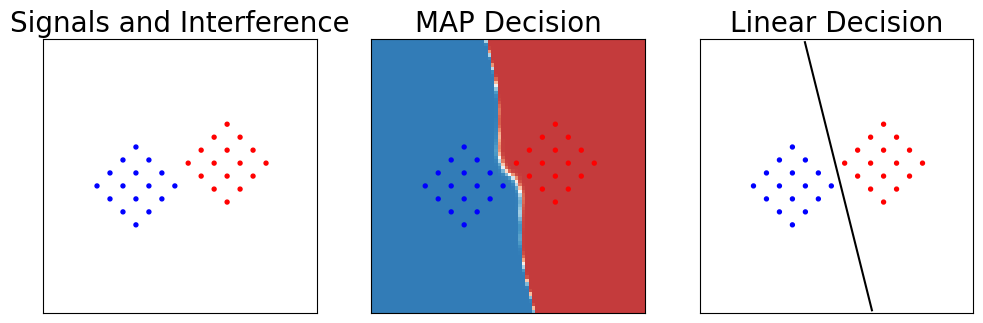

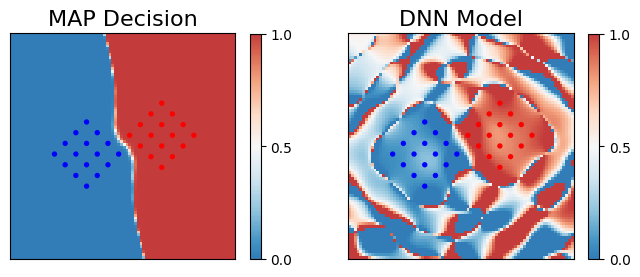

In [33]:
resolution = (80, 80) # accelerate the excecution; (150, 150)
H = np.array([[-4, -1, -1.8,  1.8 ]])
decision_plot3(H, (12, 12), resolution)
savefig()
decision_dnn_plot2(H, (12, 12), resolution)#, mask = True)
savefig()

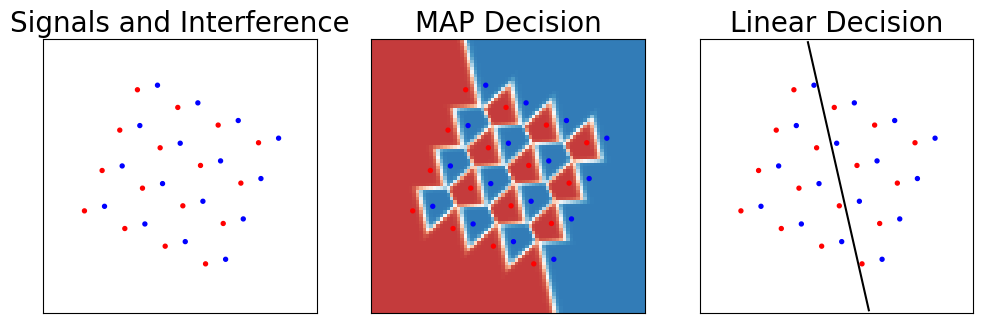

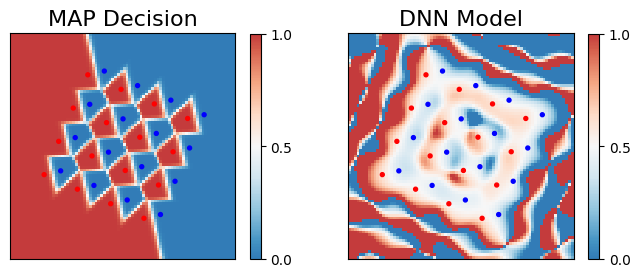

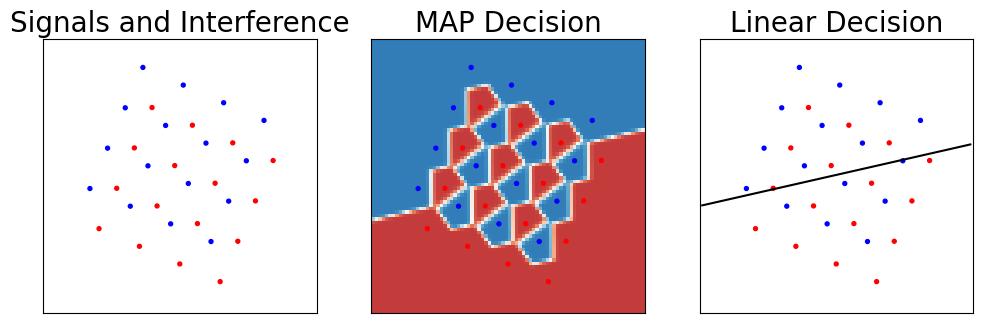

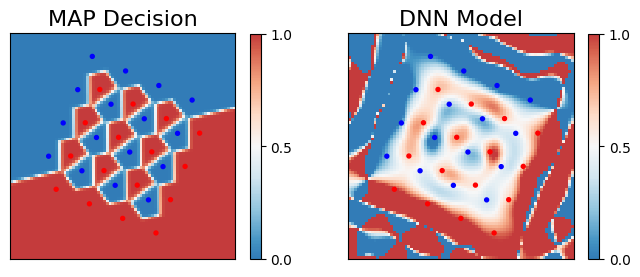

In [34]:
for H in [np.array([[0.88, 0.2, 2.45, 5.6 ]]), np.array([[-0.4, 1.76, -5.6, 2.45]])]:#r in [1, 2]:
    decision_plot3(H, (12, 12), resolution)
    savefig()
    decision_dnn_plot2(H, (12, 12), resolution)#, mask = True)
    savefig()

# for r in [1, 2]:
#     H = np.array([[0.88 * r, 0.2 * r, 2.45, 5.6 ]])
#     decision_plot3(H, (12, 12), resolution)
#     savefig()
#     decision_dnn_plot2(H, (12, 12), resolution)#, mask = True)
#     savefig()

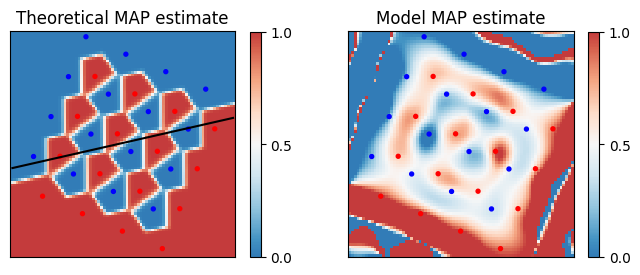

In [35]:
plot(H, (10, 10), resolution)

## More Testing Cases

Plot decisions for different $h_1$ $h_2$.

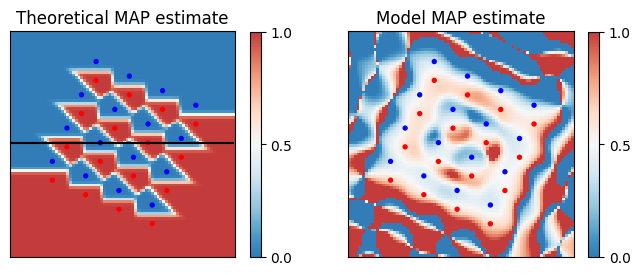

In [36]:
H = np.array([[0, 1, 2.45, 5.6 ]])
plot(H, (12, 12), resolution)

## Performance Plot

Generate Perfromance Curves reported in the Paper. This will take some time.

In [37]:
if not PLOT_PERFORMANCE_CURVE:
    raise KeyboardInterrupt("Skipping performance plotting")

KeyboardInterrupt: STOP HERE

 h1_norm =  8.0

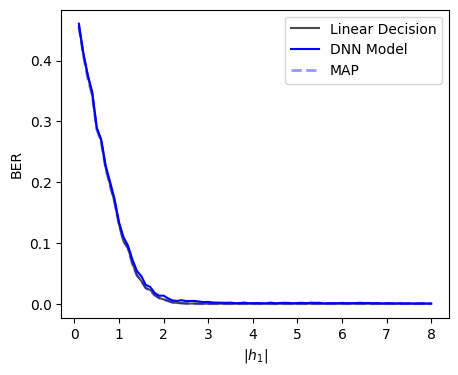

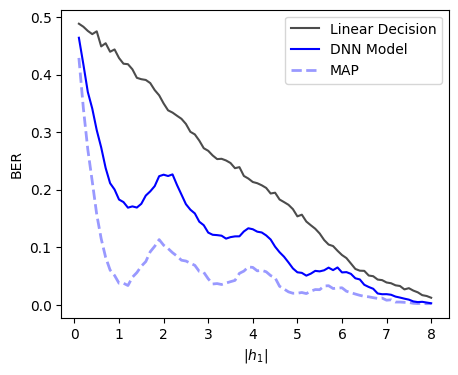

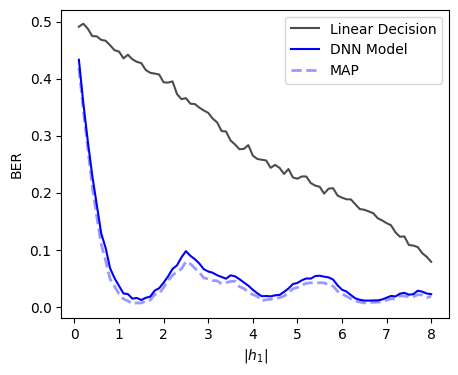

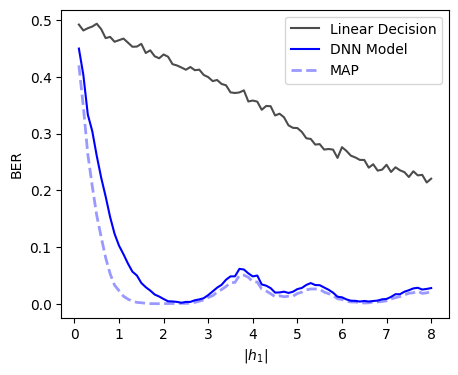

In [38]:
nTest = 10000
h1_norm_list = np.arange(0.1, 8.1, 0.1)
for h2_norm in [1, 6, 8, 12]:
    map_vals, model_vals, lin_vals = BER_test(h1_norm_list, h2_norm, nTest)
    plt.figure(figsize = (5, 4))
    plt_x = h1_norm_list
    plt.plot(plt_x, lin_vals, 'k', alpha = .7, label = 'Linear Decision')
    plt.plot(plt_x, model_vals, 'b', label = 'DNN Model')
    plt.plot(plt_x, map_vals, 'b--', linewidth = 2, alpha = .4, label = 'MAP')
    plt.xlabel('$|h_1|$')
    plt.ylabel('BER')
    plt.legend()
    savefig()




In [39]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))


In [40]:
nTest = 10000
h1_norm_list = np.arange(0.1, 8.1, 0.1)
h2_norm = 0
map_vals, model_vals, lin_vals = BER_test(h1_norm_list, h2_norm, nTest)

#savefig()

 h1_norm =  8.0

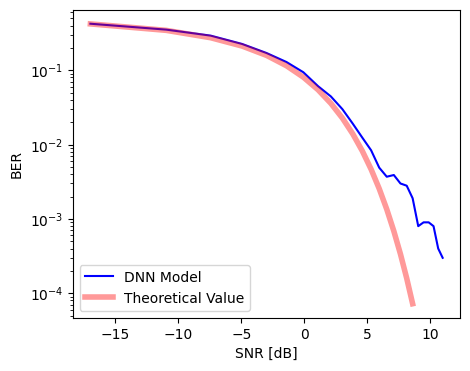

In [41]:
plt.figure(figsize = (5, 4))
plt_x = 10 * np.log10( h1_norm_list ** 2 / N_0) #20 * np.log10(h1_norm_list)


err_th = qfunc(h1_norm_list  * np.sqrt(2 / N_0))

# truncate the tails
err_th[err_th < 7e-5] = np.nan
plt_x[plt_x > 11.2] = np.nan


plt.yscale('log')
# |h2| = 0, linear = MAP
# plt.plot(plt_x, lin_vals, 'k', alpha = .7, label = 'Linear Decision')
#plt.plot(plt_x, map_vals, 'b--', linewidth = 2, alpha = .4, label = 'MAP')
plt.plot(plt_x, model_vals, 'b', label = 'DNN Model')

plt.plot(plt_x, err_th, 'r', linewidth = 4, alpha = .4, label = 'Theoretical Value')

plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.legend()
savefig()

Test: Rayleigh fading

In [42]:

def BER_Rayleigh(h1_norm_rms_list, h2_norm_rms = 0, nTest = 10000):
    # Compute BER for given h1_norm_rms in h1_norm_list and h2_norm_rms
    # randomly generate h1, h2 with fixed length
    map_vals = []
    model_vals = []
    lin_vals = []
    for h1_norm_rms in h1_norm_rms_list:
        print('\r h1_norm_rms = ', h1_norm_rms, end='')
        Y_test, h_test, X_test = [t.float() for t in gen_dataset(nTest, h1_norm_rms = h1_norm_rms, h2_norm_rms = h2_norm_rms, N_0 = N_0)]
        X1_gt = X_test[:,:2]  # ground truth of X1
        map_est = map_estimate(Y_test, h_test, N_0 = N_0)
        model_est = model_map_estimate(Y_test, h_test, model)
        lin_est = linear_decorrelator(Y_test, h_test)
        map_vals.append(BER(X1_gt, map_est))
        model_vals.append(BER(X1_gt, model_est))
        lin_vals.append(BER(X1_gt, lin_est))
    return map_vals, model_vals, lin_vals



In [43]:
h2_norm_rms = 8#6.1
# 0: error ~ 2e-4,  1: error ~ 1e-3
nTest = 10000
h1_norm_rms_list = np.arange(0.1, 8.1, 0.1)
map_vals_rms, model_vals_rms, lin_vals_rms = BER_Rayleigh(h1_norm_rms_list, h2_norm_rms, nTest)

 h1_norm_rms =  8.0

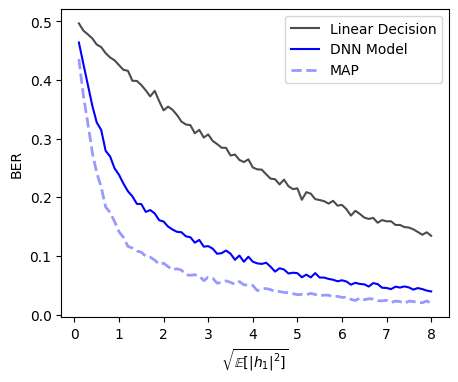

In [44]:
plt_x = h1_norm_rms_list #10 * np.log10(h1_norm_rms_list ** 2 / (1 + h2_norm_rms ** 2))
plt.figure(figsize = (5, 4))
plt.plot(plt_x, lin_vals_rms, 'k', alpha = .7, label = 'Linear Decision')
plt.plot(plt_x, model_vals_rms, 'b', label = 'DNN Model')
plt.plot(plt_x, map_vals_rms, 'b--', linewidth = 2, alpha = .4, label = 'MAP')

#plt.yscale('log')
plt.xlabel('$\sqrt{\mathbb{E}[|h_1|^2]}$')
plt.ylabel('BER')
plt.legend()
#plt.legend(['map', 'model', 'linear'])
savefig()